In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import joblib

In [2]:
# Data en labels inladen
X_ntrain          = pd.read_pickle('X_ontrain.pkl')
y_ntrain          = pd.read_pickle('y_ontrain.pkl')
X_ntrain_scaled   = pd.read_pickle('X_ontrain_scaled.pkl')
X_ntest           = pd.read_pickle('X_ontest.pkl')
y_ntest           = pd.read_pickle('y_ontest.pkl')
X_ntest_scaled    = pd.read_pickle('X_ontest_scaled.pkl')


In [3]:
# Baseline
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

results = []
for name, model in models.items():
    scores    = cross_validate(model, X_ntrain_scaled, y_ntrain, cv=cv,
                               scoring=scoring, return_train_score=True)
    y_pred_cv = cross_val_predict(model, X_ntrain_scaled, y_ntrain, cv=cv)
    tn, fp, fn, tp = confusion_matrix(y_ntrain, y_pred_cv).ravel()
    
   
    report = classification_report(y_ntrain, y_pred_cv,
                                   target_names=['Geen HVZ','HVZ'])
    
    results.append({
        'Model':        name,
        'AUC Mean':     scores['test_roc_auc'].mean(),
        'AUC Std':      scores['test_roc_auc'].std(),
        'Acc Mean':     scores['test_accuracy'].mean(),
        'Acc Std':      scores['test_accuracy'].std(),
        'Prec Mean':    scores['test_precision'].mean(),
        'Prec Std':     scores['test_precision'].std(),
        'Recall Mean':  scores['test_recall'].mean(),
        'Recall Std':   scores['test_recall'].std(),
        'F1 Mean':      scores['test_f1'].mean(),
        'F1 Std':       scores['test_f1'].std(),
        'TN':           tn,
        'FP':           fp,
        'FN':           fn,
        'TP':           tp,
    })

results_df = pd.DataFrame(results).round(3)
print("\n=== Samenvattende CV-resultaten ===")
print(results_df.to_string(index=False))

for name, model in models.items():
    y_pred_cv = cross_val_predict(model, X_ntrain_scaled, y_ntrain, cv=cv)
    cm = confusion_matrix(y_ntrain, y_pred_cv)
    print(f"\n--- {name} CV Confusion Matrix ---")
    print(f"TN: {cm[0,0]}  FP: {cm[0,1]}")
    print(f"FN: {cm[1,0]}  TP: {cm[1,1]}")
  
  



=== Samenvattende CV-resultaten ===
             Model  AUC Mean  AUC Std  Acc Mean  Acc Std  Prec Mean  Prec Std  Recall Mean  Recall Std  F1 Mean  F1 Std  TN  FP  FN  TP
LogisticRegression     0.886    0.046     0.791    0.045      0.702     0.062        0.741       0.121    0.716   0.076 123  27  22  63

--- LogisticRegression CV Confusion Matrix ---
TN: 123  FP: 27
FN: 22  TP: 63


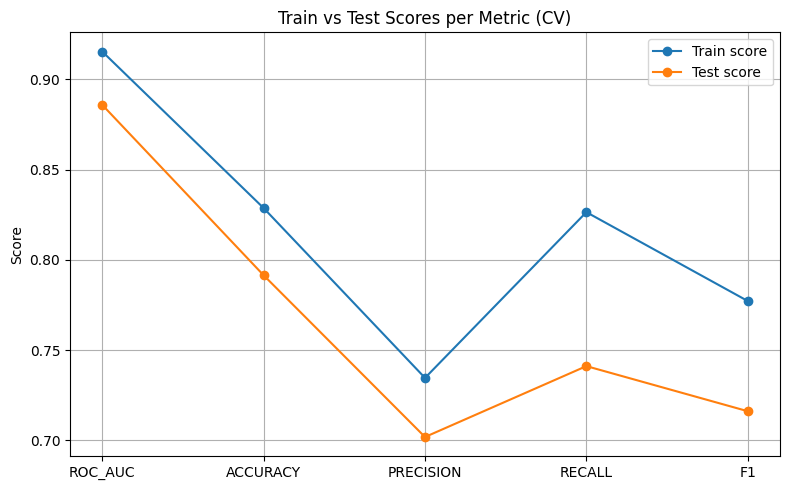

In [4]:
import matplotlib.pyplot as plt

train_means = [scores[f'train_{m}'].mean() for m in scoring]
test_means  = [scores[f'test_{m}'].mean() for m in scoring]

# Plot
x = range(len(scoring))
plt.figure(figsize=(8,5))
plt.plot(x, train_means, marker='o', label='Train score')
plt.plot(x, test_means, marker='o', label='Test score')
plt.xticks(x, [m.upper() for m in scoring])
plt.ylabel('Score')
plt.title('Train vs Test Scores per Metric (CV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Fine Tune

> Iteratie 1: Tunen van regularisatie-sterkte C

In mijn baseline model scoorde de logistic regression best goed (AUC: 0.886, accuracy: 0.791, F1: 0.716). Maar uit de cross-val plots zie ik dat de trainingsscores iets hoger liggen dan de testscores, wat kan wijzen op lichte overfitting.
Daarom kijk ik in deze stap naar het effect van de regularisatieparameter C. Door verschillende C-waardes te proberen, wil ik een betere balans vinden tussen under- en overfitting.

De parameter C bepaalt hoeveel regularisatie je toepast. Een lagere C→sterkere regularisatie (minder overfitten), een hogere C→meer vrijheid. Omdat C vaak de grootste impact heeft op de prestaties van een logistic‐regression model, gaan we daar als eerste naar kijken.

In [5]:
# Definieer je C-waarden
C_values = [0.01, 0.1, 1, 10, 100]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

rows = []
for C in C_values:
    lr = LogisticRegression(
        C=C,
        class_weight='balanced',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    scores = cross_validate(
        lr, X_ntrain_scaled, y_ntrain,
        cv=cv, scoring=scoring,
        return_train_score=False
    )
    rows.append({
        'C':                C,
        'ROC AUC Mean':     scores['test_roc_auc'].mean(),
        'Accuracy Mean':    scores['test_accuracy'].mean(),
        'Precision Mean':   scores['test_precision'].mean(),
        'Recall Mean':      scores['test_recall'].mean(),
        'F1 Mean':          scores['test_f1'].mean()
    })

results_C = pd.DataFrame(rows).round(3)
print(results_C.to_string(index=False))


     C  ROC AUC Mean  Accuracy Mean  Precision Mean  Recall Mean  F1 Mean
  0.01         0.895          0.821           0.760        0.765    0.757
  0.10         0.890          0.791           0.707        0.741    0.719
  1.00         0.886          0.791           0.702        0.741    0.716
 10.00         0.883          0.787           0.699        0.729    0.710
100.00         0.881          0.787           0.699        0.729    0.710


> Output

Bij C=0.01 zijn de scores het best, met de hoogste AUC (0.895), accuracy (0.821) en F1 (0.757). 

Omdat deze lage C-waarde zorgt voor sterkere regularisatie, is de kans op overfitting kleiner. Je ziet ook dat bij hogere C-waardes (minder regularisatie), de prestaties dalen, wat erop kan wijzen dat het model dan meer overfit op de trainingdata. Dus niet alleen zijn de scores bij C=0.01 het hoogst, maar het model is waarschijnlijk ook wat robuuster.

> Iteratie 2: Tunen van de regularisatie-vorm (penalty)

Na het tunen van de C-waarde bleek C=0.01 het beste te presteren, met sterke resultaten en minder kans op overfitting. In deze stap kijk ik of het type regularisatie invloed heeft op de prestaties. Daarom vergelijk ik L1 (Lasso) en L2 (Ridge) penalty’s, beide met C=0.01.

L1 kan zorgen voor sparsity (dus mogelijk betere generalisatie door het uitsluiten van minder belangrijke features), terwijl L2 meestal stabieler is. Door beide te testen via cross-validatie kijk ik welk type het beste past bij mijn data.


- L2 (standaard) verdeelt de straf gelijk over alle coëfficiënten.
- L1 drijft sommige coëfficiënten exact naar nul, en kan zo automatisch feature-selectie doen (handig bij veel features).

In [6]:
# Penalty-types om te vergelijken
penalties = ['l1', 'l2']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

rows = []
cms  = {}
for pen in penalties:
    lr = LogisticRegression(
        C=0.01,
        penalty=pen,
        solver='liblinear',      
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )
   
    scores = cross_validate(
        lr,
        X_ntrain_scaled, y_ntrain,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )

    y_pred_cv = cross_val_predict(lr, X_ntrain_scaled, y_ntrain, cv=cv)
    tn, fp, fn, tp = confusion_matrix(y_ntrain, y_pred_cv).ravel()
    cms[pen] = (tn, fp, fn, tp)
    
 
    rows.append({
        'penalty':          pen,
        'ROC AUC Mean':     scores['test_roc_auc'].mean(),
        'Accuracy Mean':    scores['test_accuracy'].mean(),
        'Precision Mean':   scores['test_precision'].mean(),
        'Recall Mean':      scores['test_recall'].mean(),
        'F1 Mean':          scores['test_f1'].mean(),
        'TN':               tn,
        'FP':               fp,
        'FN':               fn,
        'TP':               tp
    })


results_pen = pd.DataFrame(rows).round(3)
print("\n=== CV‐vergelijking per penalty ===")
print(results_pen.to_string(index=False))

for pen in penalties:
    tn, fp, fn, tp = cms[pen]
    print(f"\n--- Confusion Matrix voor penalty={pen} ---")
    print(f"TN: {tn}  FP: {fp}")
    print(f"FN: {fn}  TP: {tp}")



=== CV‐vergelijking per penalty ===
penalty  ROC AUC Mean  Accuracy Mean  Precision Mean  Recall Mean  F1 Mean  TN  FP  FN  TP
     l1         0.500          0.638            0.00        0.000    0.000 150   0  85   0
     l2         0.896          0.800            0.69        0.824    0.748 118  32  15  70

--- Confusion Matrix voor penalty=l1 ---
TN: 150  FP: 0
FN: 85  TP: 0

--- Confusion Matrix voor penalty=l2 ---
TN: 118  FP: 32
FN: 15  TP: 70


c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

> Output

Bij deze stap heb ik L1 en L2 regularisatie met elkaar vergeleken, beide met C=0.01. Het verschil is duidelijk:

- L1 werkt hier niet goed. Het model voorspelt geen enkele positieve klasse, wat je ook ziet aan de recall van 0.000 en TP = 0. Hierdoor is ook precision en F1-score nul. Dit betekent dat het model alle gevallen als negatief ziet, wat natuurlijk onbruikbaar is, zeker als het belangrijk is om echte positieven (zoals ziektegevallen) te herkennen.

- L2 scoort veel beter. De recall is 0.824, wat betekent dat het model ruim 82% van de echte positieve gevallen weet op te sporen. Dat is belangrijk, zeker in contexten waar het missen van een positieve case (false negatives) risicovol is. Ook precision en F1 zijn goed in balans.

Conclusie: L2 is hier duidelijk de betere keuze, vooral omdat het een hoge recall behoudt. Ik ga dus verder met L2-regularisatie, zodat het model voldoende gevoelig blijft voor de positieve klasse.

> Iteratie 3: Tunen van de klasse-gewichten (class_weight)

In de vorige stap bleek L2-regularisatie duidelijk beter dan L1, vooral omdat het model een hoge recall (0.824) behaalde, iets wat belangrijk is om de zieke klasse goed te herkennen. Nu wil ik die focus op recall verder aanscherpen.

Daarom onderzoek ik in deze iteratie het effect van verschillende class_weight-instellingen. Door de positieve klasse (HVZ) meer gewicht te geven, dwing ik het model om extra aandacht te geven aan het herkennen van zieke gevallen. Dit zou kunnen helpen om false negatives verder te verminderen, zonder dat precision of AUC daar te hard onder lijden.

In [6]:
# Waarden voor class_weight die ik wil vergelijken
weight_options = [
    'balanced',           # automatisch volgens frequenties
    {0:1, 1:2},           # 2× zoveel importance voor zieke klasse
    {0:1, 1:3},           # 3× zoveel
    {0:1, 1:5}            # 5× zoveel
]

C_best     = 0.01
penalty    = 'l2'
solver     = 'liblinear'  

cv        = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring   = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

rows = []
for cw in weight_options:
    lr = LogisticRegression(
        C=C_best,
        penalty=penalty,
        solver=solver,
        class_weight=cw,
        max_iter=1000,
        random_state=42
    )
    scores = cross_validate(
        lr, X_ntrain_scaled, y_ntrain,
        cv=cv, scoring=scoring,
        return_train_score=False
    )
 
    lr.fit(X_ntrain_scaled, y_ntrain)
    y_pred = lr.predict(X_ntrain_scaled)
    tn, fp, fn, tp = confusion_matrix(y_ntrain, y_pred).ravel()

    rows.append({
        'class_weight':   str(cw),
        'ROC AUC':        round(scores['test_roc_auc'].mean(),3),
        'Accuracy':       round(scores['test_accuracy'].mean(),3),
        'Precision':      round(scores['test_precision'].mean(),3),
        'Recall':         round(scores['test_recall'].mean(),3),
        'F1':             round(scores['test_f1'].mean(),3),
        'TN':             tn,
        'FP':             fp,
        'FN':             fn,
        'TP':             tp
    })

results_cw = pd.DataFrame(rows)
print("\n=== CV-resultaten per class_weight ===")
print(results_cw.to_string(index=False))



=== CV-resultaten per class_weight ===
class_weight  ROC AUC  Accuracy  Precision  Recall    F1  TN  FP  FN  TP
    balanced    0.896     0.800      0.690   0.824 0.748 119  31  16  69
{0: 1, 1: 2}    0.897     0.787      0.673   0.824 0.737 117  33  13  72
{0: 1, 1: 3}    0.896     0.787      0.664   0.859 0.747 112  38  10  75
{0: 1, 1: 5}    0.892     0.770      0.641   0.882 0.740 104  46   7  78


> Output

Uit de resultaten blijkt dat het verhogen van het gewicht voor de zieke klasse (class 1) een duidelijk effect heeft op de prestaties, vooral op de recall.

De optie {0:1, 1:5} scoort de hoogste recall (0.882), wat betekent dat het model bijna 88% van de zieke gevallen correct herkent. Ook het aantal false negatives is het laagst (FN = 7), een groot voordeel als je vooral geen positieve gevallen wilt missen.

Hoewel precision iets daalt (0.641) en accuracy ook wat lager is (0.770), blijft de F1-score stabiel (0.740) en de AUC nog steeds hoog (0.892). Dat betekent dat de balans tussen gevoeligheid en betrouwbaarheid goed blijft, ondanks de verschuiving naar meer nadruk op recall.

Conclusie: {0:1, 1:5} wint deze ronde. Het model herkent meer zieke gevallen met nauwelijks prestatieverlies op de andere metrics, precies het doel van deze stap.

> Iteratie 4: Keuze van solver

Tot nu toe heb ik de best presterende combinatie gevonden met C=0.01, L2-regularisatie, en een class weight van {0:1, 1:5} om de focus op recall te leggen. In deze stap onderzoek ik welk solver-algoritme het beste werkt met deze instellingen.

Scikit-learn biedt meerdere solvers om het logistiek regressiemodel te optimaliseren, zoals liblinear, lbfgs, sag en saga. Elk van deze solvers werkt iets anders en kan qua snelheid, stabiliteit of prestaties verschillen, zeker bij ongebalanceerde data of wanneer class_weight wordt gebruikt.

Daarom vergelijk ik nu de solvers met cross-validatie om te zien welke het beste presteert op AUC, recall en F1-score, zonder de balans te verliezen.

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix

# Kandidaten voor solver definieren
solvers = ['lbfgs', 'liblinear', 'sag', 'saga']

C_best       = 0.01
penalty      = 'l2'
class_weight = {0:1, 1:5}

cv      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

rows = []
cms  = {}
for sv in solvers:
    lr = LogisticRegression(
        C=C_best,
        penalty=penalty,
        solver=sv,
        class_weight=class_weight,
        max_iter=2000,
        random_state=42
    )
    scores = cross_validate(
        lr, X_ntrain_scaled, y_ntrain,
        cv=cv, scoring=scoring,
        return_train_score=False
    )

    y_pred_cv = cross_val_predict(lr, X_ntrain_scaled, y_ntrain, cv=cv)
    tn, fp, fn, tp = confusion_matrix(y_ntrain, y_pred_cv).ravel()
    cms[sv] = (tn, fp, fn, tp)
    
   
    rows.append({
        'solver':           sv,
        'ROC AUC Mean':     scores['test_roc_auc'].mean(),
        'Accuracy Mean':    scores['test_accuracy'].mean(),
        'Precision Mean':   scores['test_precision'].mean(),
        'Recall Mean':      scores['test_recall'].mean(),
        'F1 Mean':          scores['test_f1'].mean(),
        'TN':               tn,
        'FP':               fp,
        'FN':               fn,
        'TP':               tp
    })


results_solver = pd.DataFrame(rows).round(3)
print("\n=== CV-resultaten per solver ===")
print(results_solver.to_string(index=False))

for sv in solvers:
    tn, fp, fn, tp = cms[sv]
    print(f"\n--- CM voor solver={sv} ---")
    print(f"TN: {tn}  FP: {fp}")
    print(f"FN: {fn}  TP: {tp}")



=== CV-resultaten per solver ===
   solver  ROC AUC Mean  Accuracy Mean  Precision Mean  Recall Mean  F1 Mean  TN  FP  FN  TP
    lbfgs         0.893          0.677           0.534        0.929    0.677  80  70   6  79
liblinear         0.892          0.770           0.641        0.882    0.740 106  44  10  75
      sag         0.893          0.677           0.534        0.929    0.677  80  70   6  79
     saga         0.893          0.677           0.534        0.929    0.677  80  70   6  79

--- CM voor solver=lbfgs ---
TN: 80  FP: 70
FN: 6  TP: 79

--- CM voor solver=liblinear ---
TN: 106  FP: 44
FN: 10  TP: 75

--- CM voor solver=sag ---
TN: 80  FP: 70
FN: 6  TP: 79

--- CM voor solver=saga ---
TN: 80  FP: 70
FN: 6  TP: 79


> Output

Uit de vergelijking van de vier solvers blijkt dat lbfgs, sag en saga nagenoeg identiek presteren, met een zeer hoge recall van 0.929 en een lage false negative count (FN = 6). Dat betekent dat deze modellen bijna alle positieve gevallen correct herkennen, wat aansluit bij mijn doel om recall te maximaliseren.

Hoewel liblinear iets gebalanceerder scoort qua precision en accuracy (met minder false positives), levert het wel een lagere recall (0.882) en een iets lagere true positive count (TP = 75 vs 79).

Conclusie: Omdat het herkennen van zieke gevallen (recall) voor mij het belangrijkste is in dit project, kies ik bewust voor de lbfgs-solver. Die haalt het hoogste aantal true positives met de laagste FN, en past dus het best bij mijn prioriteiten.

> Iteratie 5: Optimaliseren van de classificatie‐drempel (threshold)

Tot nu toe heb ik het model stapsgewijs verbeterd met de beste hyperparameters: C=0.01, L2-regularisatie, class weight {0:1, 1:5}, en de lbfgs-solver. Daarmee is vooral de recall sterk verhoogd, wat belangrijk is om zieke gevallen goed op te sporen.

In deze laatste stap kijk ik niet meer naar de hyperparameters, maar naar de beslissingsdrempel zelf. Standaard gebruikt logistic regression een drempel van 0.5, maar dat is niet altijd optimaal, zeker niet bij ongebalanceerde data of als recall belangrijker is dan precision.

Daarom zoek ik nu via cross-validatie naar de drempel waarbij de F1-score maximaal is, zodat de balans tussen precision en recall optimaal wordt afgestemd op mijn doel.

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve

lr = LogisticRegression(
    C=0.01,
    penalty='l2',
    solver='lbfgs',
    class_weight={0:1,1:5},
    max_iter=2000,
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_scores = cross_val_predict(
    lr,
    X_ntrain_scaled, y_ntrain,
    cv=cv,
    method='predict_proba'
)[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_ntrain, y_scores)

df_thresh = pd.DataFrame({
    'threshold': np.append(thresholds, 1.0), 
    'precision': precisions,
    'recall': recalls
})

df_thresh['f1'] = 2 * (df_thresh.precision * df_thresh.recall) / (df_thresh.precision + df_thresh.recall)

best_idx = df_thresh['f1'].idxmax()
best = df_thresh.loc[best_idx]

print(f" Beste threshold (max F1): {best.threshold:.3f}")
print(f"   Precision: {best.precision:.3f}, Recall: {best.recall:.3f}, F1: {best.f1:.3f}")

lr.fit(X_ntrain_scaled, y_ntrain)
probs = lr.predict_proba(X_ntrain_scaled)[:,1]
y_pred_opt = (probs >= best.threshold).astype(int)

cm = confusion_matrix(y_ntrain, y_pred_opt)
print("\nConfusion Matrix bij optimale drempel:")
print(f"TN: {cm[0,0]}  FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}  TP: {cm[1,1]}")

print("\nClassification Report bij optimale drempel:")
print(classification_report(y_ntrain, y_pred_opt, target_names=['Geen HVZ','HVZ']))


 Beste threshold (max F1): 0.672
   Precision: 0.689, Recall: 0.859, F1: 0.764

Confusion Matrix bij optimale drempel:
TN: 117  FP: 33
FN: 11  TP: 74

Classification Report bij optimale drempel:
              precision    recall  f1-score   support

    Geen HVZ       0.91      0.78      0.84       150
         HVZ       0.69      0.87      0.77        85

    accuracy                           0.81       235
   macro avg       0.80      0.83      0.81       235
weighted avg       0.83      0.81      0.82       235



> Output:

Door de classificatiedrempel te optimaliseren in plaats van vast te houden aan de standaard 0.5, vond ik een nieuwe drempel van 0.672 die de hoogste F1-score (0.764) oplevert. Hiermee verbetert de balans tussen precision en recall duidelijk.

- Recall blijft hoog (0.859): het model herkent bijna 86% van de zieke gevallen.
- Precision is 0.689, wat acceptabel is gezien de focus op het terugvinden van positieven.
- De confusion matrix laat zien dat het aantal false negatives beperkt blijft (FN = 11) en het aantal true positives hoog is (TP = 74).
- Ook de accuracy (0.81) en het hele classification report bevestigen dat het model goed presteert, met een sterke macro en weighted F1-score.

Conclusie: Het aanpassen van de drempel is effectief geweest. Deze stap haalt het maximale uit het model door de focus op recall te behouden, zonder teveel in te leveren op precisie.

### Opslaan Final Model Logistic Regression

In [ ]:
import joblib

joblib.dump(lr, 'nfinal_logreg_model.pkl')

joblib.dump(best.threshold, 'nfinal_logreg_threshold.pkl')

print(" Model opgeslagen als 'nfinal_logreg_model.pkl'")
print(f" Drempel opgeslagen als 'nfinal_logreg_threshold.pkl' (value = {best.threshold:.3f})")


 Model opgeslagen als 'nfinal_logreg_model.pkl'
 Drempel opgeslagen als 'nfinal_logreg_threshold.pkl' (value = 0.672)
